<a href="https://colab.research.google.com/github/Hoopoe11/Lab/blob/main/projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projekt:
**Program do klasyfikacji zdjęć z zestawu CIFAR-100. Wykorzystujący sieć konwolucyjną, augmentację, K-folding i optymalizację Optuną.**

Zestaw danych CIFAR-100 jest podobny do CIFAR-10, z wyjątkiem tego, że ma 100 klas zawierających po 600 obrazów. Na klasę przypada 500 obrazów szkoleniowych i 100 obrazów testowych. 100 klas w CIFAR-100 jest pogrupowanych w 20 superklas. Każdy obraz ma etykietę „dobra” (klasa, do której należy) i etykietę „zgrubną” (nadklasa, do której należy).




In [ ]:
#biblioteki
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping

from sklearn.model_selection import KFold

In [ ]:
#wczytanie danych z cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
img_rows, img_cols , channels= 32,32,3

N_TRAIN_EXAMPLES = 1500  
N_CLASSES = 3

print("Original data")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

indices = np.where(y_train < N_CLASSES) 
indices = indices[0]
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]


indices = np.where(y_test < N_CLASSES) 
indices = indices[0]
np.random.shuffle(indices)
x_test = x_test[indices]
y_test = y_test[indices]


x_train = x_train[:N_TRAIN_EXAMPLES] 
y_train = y_train[:N_TRAIN_EXAMPLES]

print(" ")
print("Truncated data")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



Original data
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
 
Truncated data
(1500, 32, 32, 3)
(1500, 1)
(300, 32, 32, 3)
(300, 1)


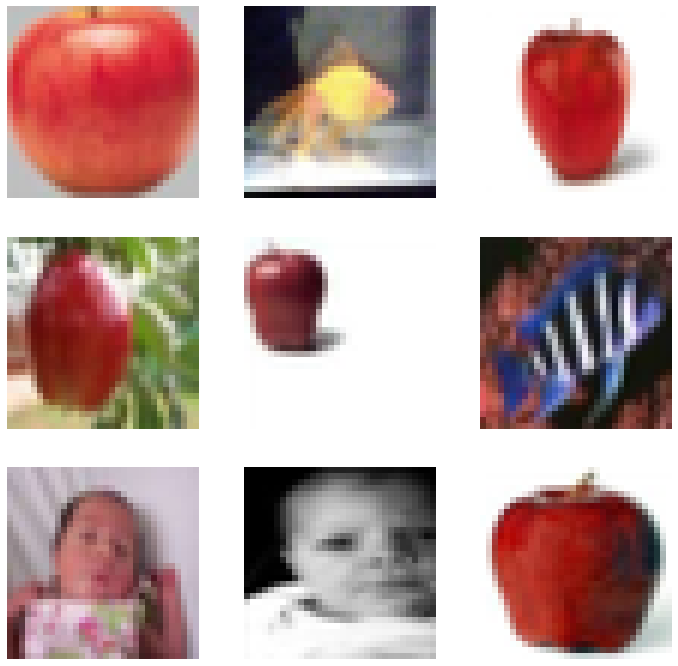

In [ ]:
# save x_test images
xx_test = x_test
yy_test = y_test

fig = plt.figure(figsize=(12, 12))
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    plt.imshow(x_train[i])
plt.show()

In [ ]:
# augumentacja

rotation_range=30
shift_range=0.30

datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=shift_range
      )  


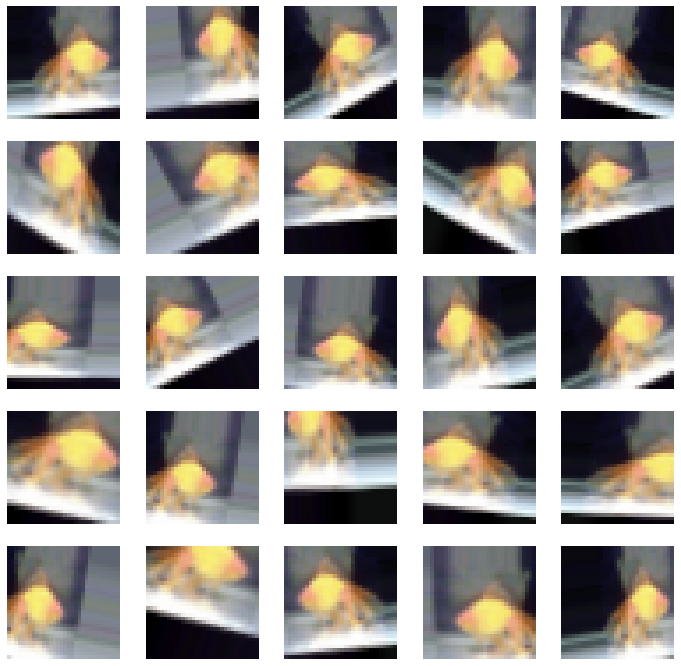

In [ ]:
# przykład augumentacji na jednym obrazku
fig = plt.figure(figsize=(12, 12))

for i in range(0, 25):
    for X_batch, y_batch in datagen.flow(x_train[1:3], y_train[1:3], batch_size=1, shuffle=False):
         plt.subplot(5,5,i+1)
         plt.imshow(X_batch[0].astype(np.uint8))
         plt.axis('off')
         break

plt.show()

In [ ]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (1500, 32, 32, 3)
1500 train samples
300 test samples


In [ ]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

# labels to categorical - output is a vector with length = number of classes
y_train = k.utils.to_categorical(y_train, N_CLASSES)
y_test = k.utils.to_categorical(y_test, N_CLASSES)

In [ ]:
#stworzenie sieci konwolucyjnej
def create_model(num_filters2):

  #reg=l2(1e-4)   # L2 or "ridge" regularisation
  reg2=None
  #num_filters2=32
  ac2='relu'
  adm2=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  opt2=adm2
  drop_dense2=0.5
  drop_conv2=0

  model2 = Sequential()

  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2, kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
  model2.add(Dropout(drop_conv2))


  model2.add(Flatten())
  model2.add(Dense(512, activation=ac2,kernel_regularizer=reg2))
  model2.add(BatchNormalization())
  model2.add(Dropout(drop_dense2))
  model2.add(Dense(N_CLASSES, activation='softmax'))

  model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

  return model2

In [ ]:
#dopasowanie sieci konwolucyjnej
def fit_model(model2, datagen, x_train, y_train, x_val, y_val):

  # train with image augmentation

  es = EarlyStopping(
    monitor="val_accuracy",
    patience=60,
    verbose=1
  )

  history2=model2.fit(datagen.flow(x_train, y_train, batch_size=128),
                     batch_size=128, epochs=150, validation_data=(x_val, y_val), verbose=0)
  return history2, model2

In [ ]:
# OPTUNA

! pip install optuna
import optuna

In [ ]:
# szacowanie modelu z k-fold i cross-validation
def evaluate_model(dataX, dataY, n_folds=5, datagen=datagen, num_filters=32):

  scores=[]
  histories=[]
  models=[]

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
      model = create_model(num_filters)
    # select rows for train and test
      trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
      history, model = fit_model(model, datagen, trainX, trainY, testX, testY)
    # evaluate model
      _, acc = model.evaluate(testX, testY, verbose=0)
      print('> %.3f' % (acc * 100.0))
		# stores scores
      scores.append(acc)
      histories.append(history)
      models.append(model)
  return scores, histories, models

In [ ]:
def objective(trial):
  
  rotation_range=trial.suggest_uniform('rotation_range', .00,30)
  shift_range=trial.suggest_uniform('shift_range', .00,0.20)
  num_filters =trial.suggest_uniform('num_filters', .00,50)
  
  datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=shift_range
  )
  datagen.fit(x_train)


  #create and evaluate model
  scores, histories, models = evaluate_model(x_train, y_train, n_folds=5, datagen=datagen, num_filters=num_filters)

  return np.mean(scores)

In [ ]:
#Optymalizacja
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )
study.optimize(objective, n_trials=30, timeout=1200)

[I 2021-01-04 15:36:00,757] A new study created in memory with name: no-name-0ad82317-c1de-4efb-bea5-27f0832ca1d7


> 91.000
> 90.333
> 94.333
> 92.000


[I 2021-01-04 15:44:26,208] Trial 0 finished with value: 0.9213333368301392 and parameters: {'rotation_range': 6.2785233475606725, 'shift_range': 0.11235947204590922, 'num_filters': 19.32251795118897}. Best is trial 0 with value: 0.9213333368301392.


> 93.000
> 87.333
> 90.667
> 93.000
> 97.000


[I 2021-01-04 15:53:20,397] Trial 1 finished with value: 0.9253333449363709 and parameters: {'rotation_range': 2.4913274711209485, 'shift_range': 0.09099397782422292, 'num_filters': 41.4663157358712}. Best is trial 1 with value: 0.9253333449363709.


> 94.667
> 92.000
> 89.667
> 89.667
> 94.000


[I 2021-01-04 16:02:27,636] Trial 2 finished with value: 0.9120000004768372 and parameters: {'rotation_range': 27.11039948972928, 'shift_range': 0.007509476985080355, 'num_filters': 47.976196315585014}. Best is trial 1 with value: 0.9253333449363709.


> 90.667


In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


Number of finished trials: 3
Best trial:
  Value: 0.9253333449363709
  Params: 
    rotation_range: 2.4913274711209485
    shift_range: 0.09099397782422292
    num_filters: 41.4663157358712


In [ ]:
# trening z zoptymalizowanymi parametrami
num_filters =trial.params.get('num_filters') 
rotation_range=trial.params.get('rotation_range')
shift_range=trial.params.get('shift_range')
  
datagen = ImageDataGenerator( 
    rotation_range=rotation_range,
    width_shift_range=shift_range,
    height_shift_range=shift_range,
    zoom_range=shift_range
    )

datagen.fit(x_train)

#create and evaluate model
scores, histories, models = evaluate_model(x_train, y_train, n_folds=5, datagen=datagen)

> 91.000
> 92.000
> 92.333
> 95.000
> 90.000


In [ ]:
#Wykresy
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))
  for i in range(len(histories)):
		# plot loss
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    #plt.ylim(0,0.1)
    plt.legend(['loss','val_loss'])
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    #plt.ylim(0.9,1)
    plt.legend(['accuracy','val_accuracy'])
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
  plt.figure(figsize=(10,10))
  plt.boxplot(scores)
  plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



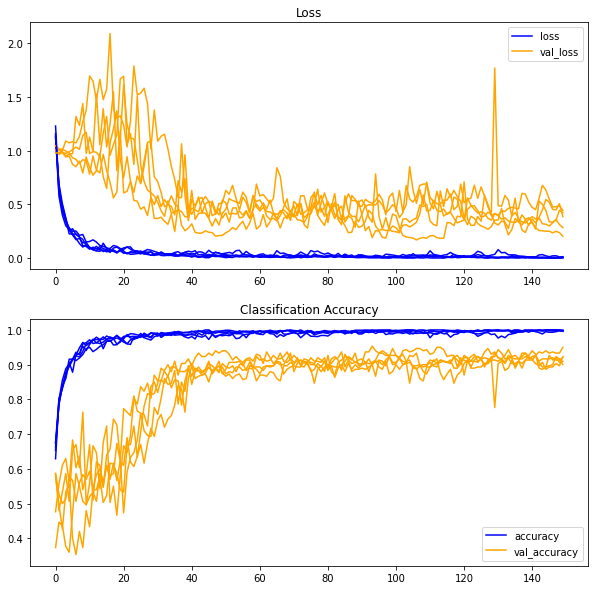

Accuracy: mean=92.067 std=1.679, n=5


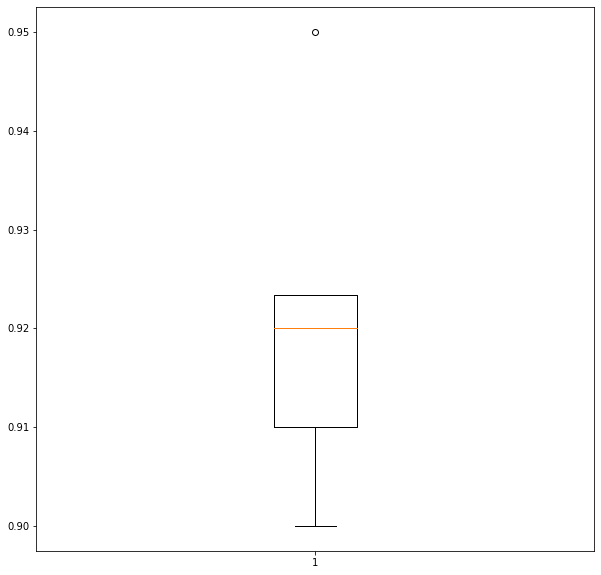

Scores:  [0.9100000262260437, 0.9200000166893005, 0.9233333468437195, 0.949999988079071, 0.8999999761581421]


In [ ]:
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
 
print("Scores: ",scores)

In [ ]:
# make predictions
yhats = [model.predict(x_test) for model in models]
yhats = np.array(yhats)
# sum across ensembles
summed = np.sum(yhats, axis=0)/len(models)
# argmax across classes
outcomes = np.argmax(summed, axis=1)

# true outcomes
outcomes_true = np.argmax(y_test,axis = 1)


score = (len(outcomes) - np.count_nonzero(outcomes-outcomes_true))/len(outcomes)

print("Ensamble test accuracy: ",score*100.,"%")


Ensamble test accuracy:  95.0 %


In [ ]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix

#confusion matrix
cm = confusion_matrix(outcomes_true,outcomes)
print(cm)



[[95  0  5]
 [ 0 98  2]
 [ 2  6 92]]


In [ ]:
def plot_images2(y_pred, y_pred_prob):
# Names of predicted classes (randomly chosen images)

  import random


  class_names = ["apple", "fish", "child", "bear", "beaver", "bed", "bee", "horse", "ship", "truck"]

  #y_pred = model2.predict_classes(x_test)
  #y_pred_prob = model2.predict(x_test)

  grid_w = 10
  grid_h = 10

  fig = plt.figure(figsize=(20, 40))
  for i in range(0,grid_w*grid_h):
    i_pos = 2*(int(i/grid_w))*grid_w+ i%grid_w + 1
    #print(i_pos)
    plt.subplot(2*grid_h, grid_w, i_pos)
    i_img = random.randint(0,len(xx_test))
    plt.imshow(xx_test[i_img])
    #plt.bar([0,1,2,3,4,5,6,7,8,9],y_test[i_img])
    plt.axis('off')
    if yy_test[i_img] == y_pred[i_img]:
      plt.text(0, -2, class_names[int(yy_test[i_img])], color='green', fontsize=12)
    else:
      plt.text(0, -2, class_names[int(yy_test[i_img])]+" "+class_names[y_pred[i_img]], color='red', fontsize=12)  
    plt.subplot(2*grid_h, grid_w, i_pos + grid_w)
    xbar = np.linspace(1, N_CLASSES, num=N_CLASSES)
    plt.bar(xbar,y_pred_prob[i_img])
    plt.axis('off')

  plt.show()


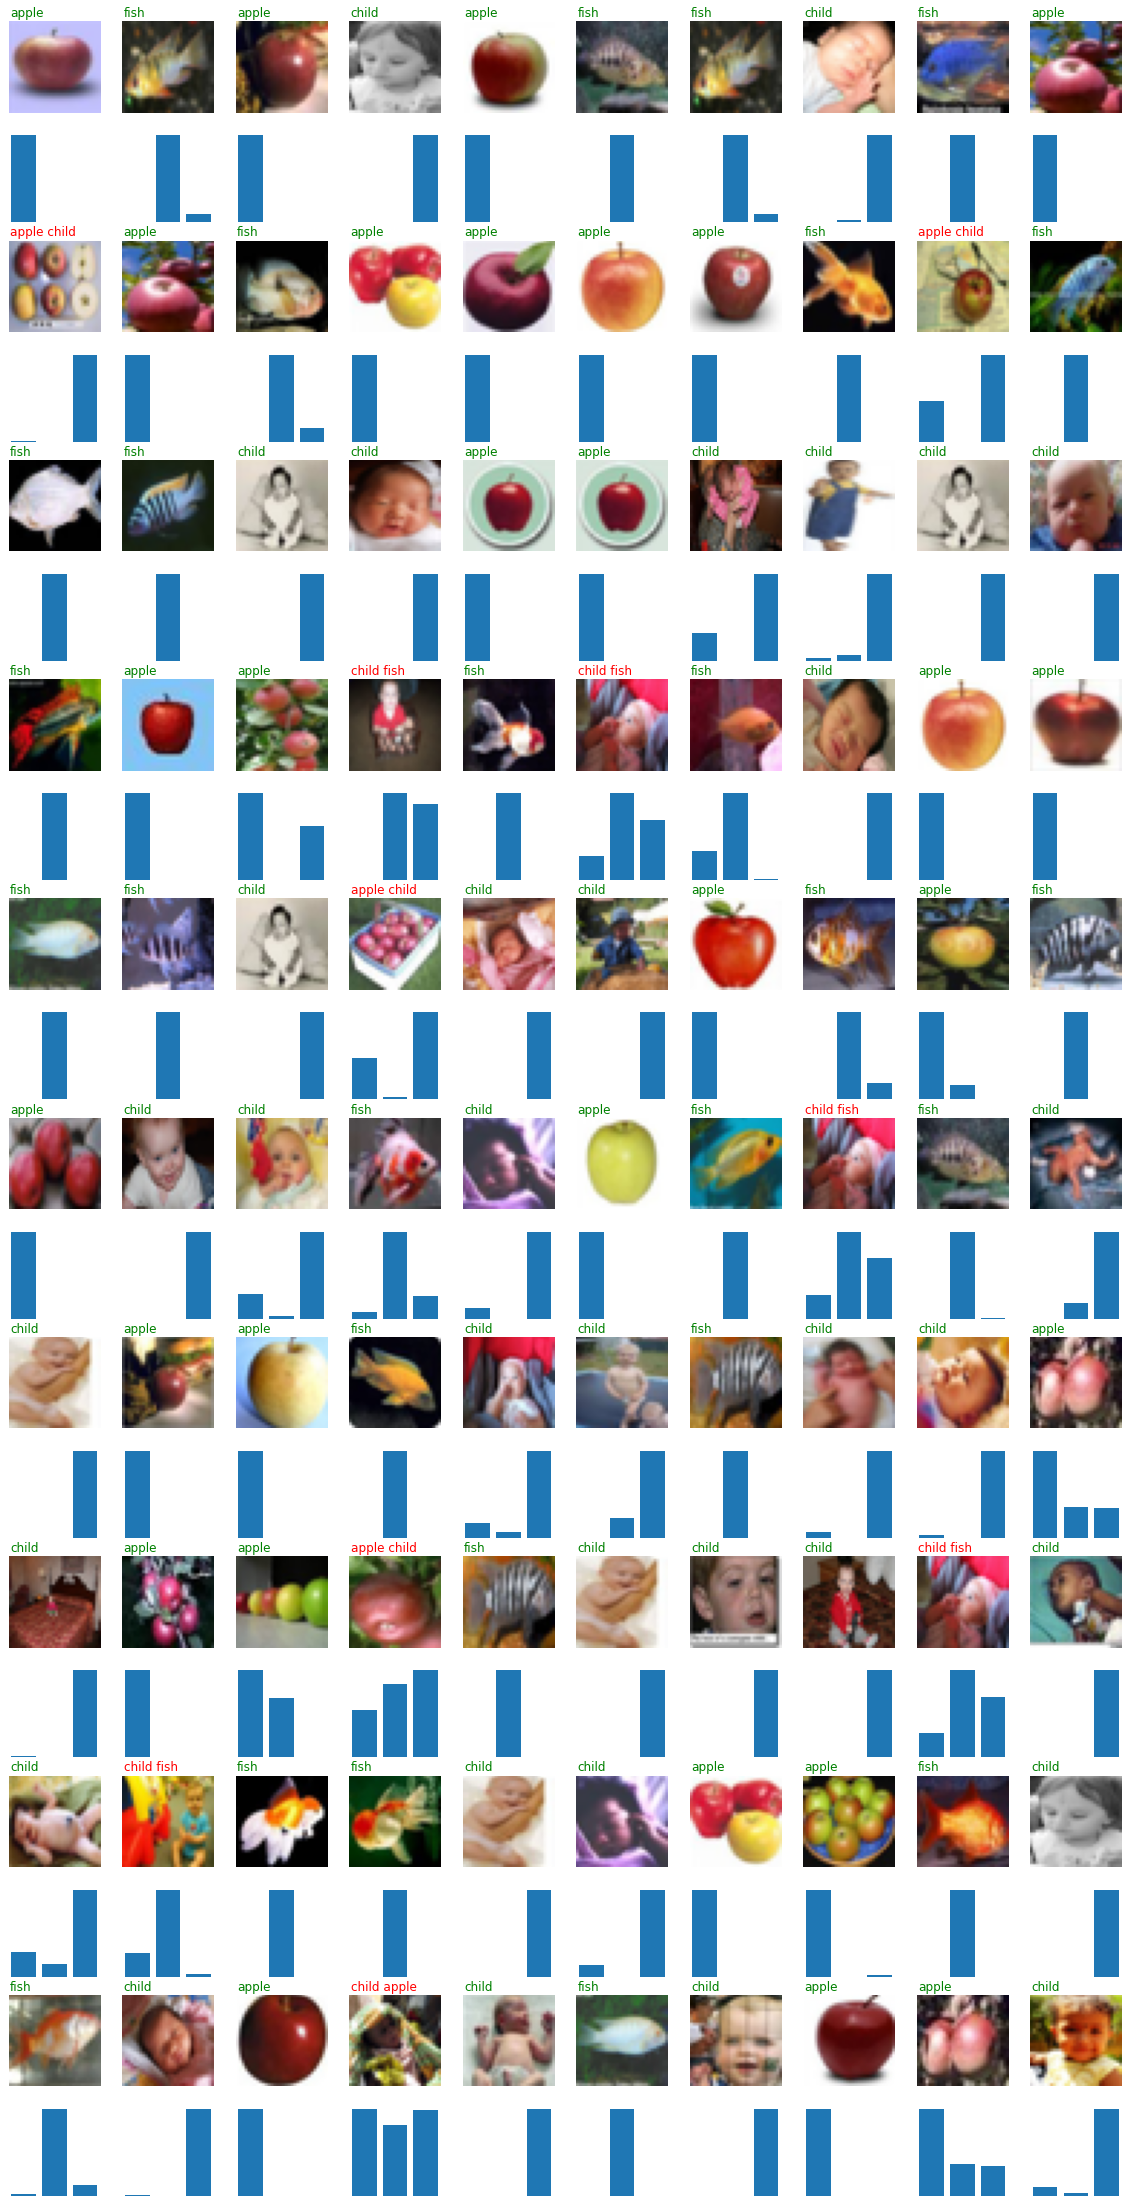

In [ ]:
plot_images2(outcomes,summed)

# Wizualizacje

In [ ]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

In [ ]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study)

In [ ]:
from optuna.visualization import plot_contour

plot_contour(study)

In [ ]:
from optuna.visualization import plot_slice

plot_slice(study)

In [ ]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)